Сгенерируем тестовые сигналы:

In [546]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import find_peaks, spectrogram
from scipy.ndimage import gaussian_filter1d

In [547]:
fs = 8000 
duration = 0.5  
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

f0 = 200  

# Чистый синус
sine_wave = 0.5 * np.sin(2 * np.pi * f0 * t)

# Гармонический сигнал
harmonic_signal = (0.3 * np.sin(2 * np.pi * f0 * t) +
                   0.8 * np.sin(2 * np.pi * 2 * f0 * t) +
                   0.6 * np.sin(2 * np.pi * 3 * f0 * t) +
                   0.4 * np.sin(2 * np.pi * 4 * f0 * t) +
                   0.2 * np.sin(2 * np.pi * 5 * f0 * t))

# Сигнал с пропущенной фундаментальной
missing_f0 = (0.8 * np.sin(2 * np.pi * 2 * f0 * t) +
              0.6 * np.sin(2 * np.pi * 3 * f0 * t) +
              0.4 * np.sin(2 * np.pi * 4 * f0 * t) +
              0.2 * np.sin(2 * np.pi * 5 * f0 * t))

# Сигнал с небольшим шумом
noisy_signal = harmonic_signal + 0.1 * np.random.randn(len(t))

# Нормализация
sine_wave = sine_wave / np.max(np.abs(sine_wave))
harmonic_signal = harmonic_signal / np.max(np.abs(harmonic_signal))
missing_f0 = missing_f0 / np.max(np.abs(missing_f0))
noisy_signal = noisy_signal / np.max(np.abs(noisy_signal))

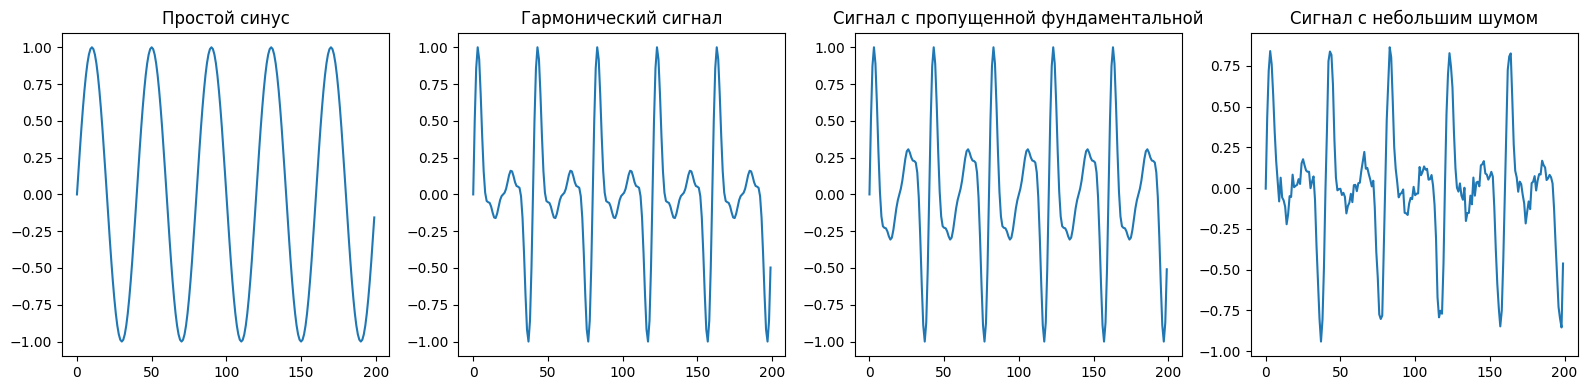

In [548]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.plot(sine_wave[:200])
plt.title('Простой синус')

plt.subplot(1, 4, 2)
plt.plot(harmonic_signal[:200])
plt.title('Гармонический сигнал')

plt.subplot(1, 4, 3)
plt.plot(missing_f0[:200])
plt.title('Сигнал с пропущенной фундаментальной')

plt.subplot(1, 4, 4)
plt.plot(noisy_signal[:200])
plt.title('Сигнал с небольшим шумом')

plt.tight_layout()
plt.show()

In [549]:
from scipy.fft import fft, rfft, ifft, fftfreq, rfftfreq

sine_wave_spectrum = np.abs(rfft(sine_wave))
harmonic_spectrum = np.abs(rfft(harmonic_signal))
missing_f0_spectrum = np.abs(rfft(missing_f0))
noisy_spectrum = np.abs(rfft(noisy_signal))

freqs = rfftfreq(int(fs * duration), 1 / fs)

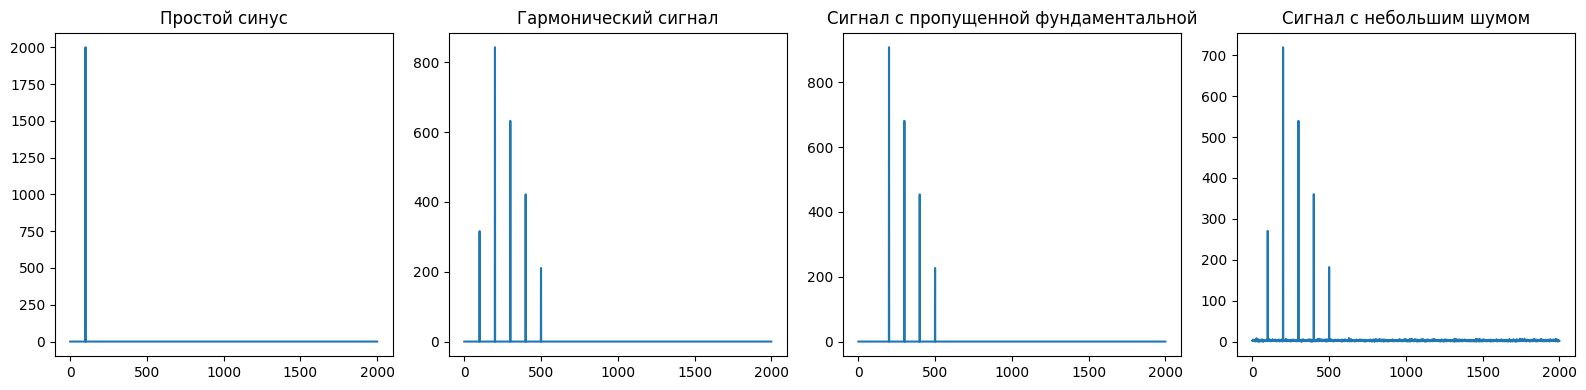

In [550]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.plot(sine_wave_spectrum)
plt.title('Простой синус')

plt.subplot(1, 4, 2)
plt.plot(harmonic_spectrum)
plt.title('Гармонический сигнал')

plt.subplot(1, 4, 3)
plt.plot(missing_f0_spectrum)
plt.title('Сигнал с пропущенной фундаментальной')

plt.subplot(1, 4, 4)
plt.plot(noisy_spectrum)
plt.title('Сигнал с небольшим шумом')

plt.tight_layout()
plt.show()

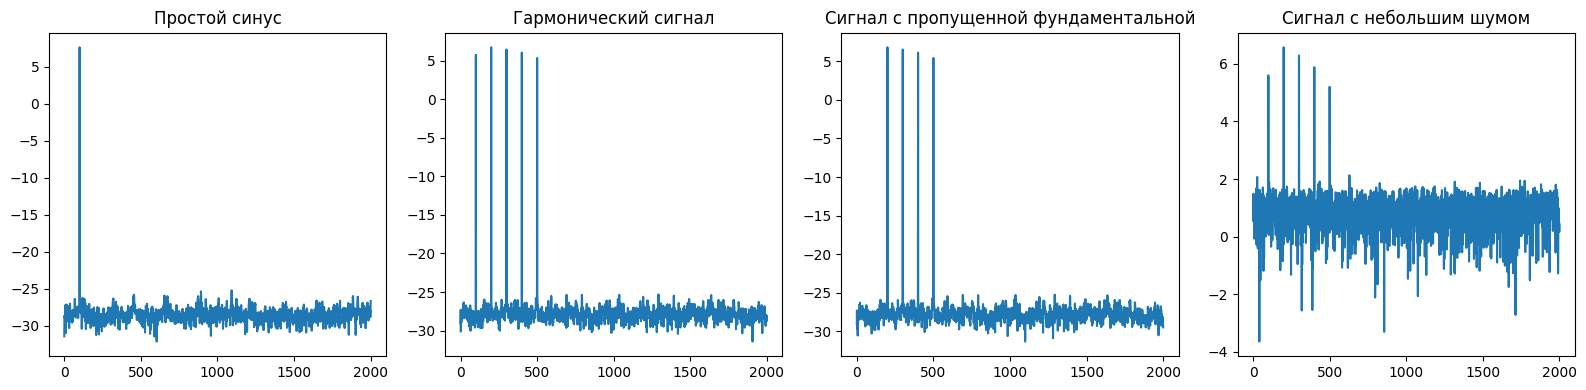

In [551]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.plot(np.log(sine_wave_spectrum))
plt.title('Простой синус')

plt.subplot(1, 4, 2)
plt.plot(np.log(harmonic_spectrum))
plt.title('Гармонический сигнал')

plt.subplot(1, 4, 3)
plt.plot(np.log(missing_f0_spectrum))
plt.title('Сигнал с пропущенной фундаментальной')

plt.subplot(1, 4, 4)
plt.plot(np.log(noisy_spectrum))
plt.title('Сигнал с небольшим шумом')

plt.tight_layout()
plt.show()

<h2>Метод 1: Harmonic Sieve (Гармоническое решето)</h2>

 Harmonic Sieve Method (Piszczalski & Galler, 1979) <br/>

 Идея: Найти такую f0, чтобы большинство спектральных пиков были близки к гармоникам (целым кратным f0)

In [552]:
def find_spectral_peaks(spectrum, freqs, min_freq=50, max_freq=500, n_peaks=10):
    """
    Находит пики в спектре
    """
    # Ограничиваем диапазон частот
    freq_mask = (freqs >= min_freq) & (freqs <= max_freq)
    freqs_limited = freqs[freq_mask]
    spectrum_limited = spectrum[freq_mask]
    
    # Находим пики
    peaks, properties = find_peaks(spectrum_limited, 
                                   height=np.max(spectrum_limited)*0.1)
                              
    
    # Сортируем по амплитуде
    peak_amplitudes = properties['peak_heights']
    sorted_idx = np.argsort(peak_amplitudes)[::-1]

    
    n_peaks = min(n_peaks, len(peaks))
    if n_peaks > 0:
        peaks = peaks[sorted_idx[:n_peaks]]
        peak_freqs = freqs_limited[peaks]
        peak_amps = peak_amplitudes[sorted_idx[:n_peaks]]
        return peak_freqs, peak_amps
    else:
        return np.array([]), np.array([])

In [553]:
def harmonic_match_score(f0_candidate, peak_freqs, peak_amps, tolerance=0.02):
        """
        Оценка того, насколько хорошо f0_candidate объясняет пики
        """
        score = 0
        matched_harmonics = []
        
        for freq, amp in zip(peak_freqs, peak_amps):
            # К какому номеру гармоники ближе всего?
            harmonic_number = round(freq / f0_candidate)
            if harmonic_number < 1:
                continue
                
            expected_freq = harmonic_number * f0_candidate
            deviation = abs(freq - expected_freq) / expected_freq
            
            if deviation < tolerance:
                # Вес пропорционален амплитуде и обратно пропорционален отклонению
                weight = amp * (1 - deviation / tolerance)
                weight = amp * (1 - deviation / tolerance) / harmonic_number
                score += weight
                matched_harmonics.append(harmonic_number)
        
        return score, matched_harmonics

In [554]:
    def estimate(audio_frame, fs, min_f0, max_f0):
        """
        Оценка f0 для одного фрейма
        """
        # Вычисляем спектр
        spectrum = np.abs(rfft(audio_frame))
        freqs = rfftfreq(len(audio_frame), 1/fs)
        
        # Находим пики
        peak_freqs, peak_amps = find_spectral_peaks(spectrum, freqs)
        
        # Перебираем кандидатов f0
        f0_candidates = np.linspace(min_f0, max_f0, 200)
        scores = []
        matched_patterns = []

        print("Координаты пиков: ", peak_freqs)
        
        for f0_cand in f0_candidates:
            score, matches = harmonic_match_score(f0_cand, peak_freqs, peak_amps)
            if score > 50:
                print(f0_cand, score)
            scores.append(score)
            matched_patterns.append(matches)
        
        # Выбираем лучшего кандидата
        best_idx = np.argmax(scores)
        best_f0 = f0_candidates[best_idx]
        best_score = scores[best_idx]
        
        return best_f0, best_score, matched_patterns[best_idx]

In [555]:
f0_est, score, matches = estimate(sine_wave, fs, 50, 500)
f0_est

Координаты пиков:  [200.]
50.0 499.9999999999999
65.82914572864321 242.57845631891462
99.74874371859296 874.055415617127
196.98492462311557 469.387755102039
199.24623115577887 1621.6897856242003
201.5075376884422 1251.870324189532
203.76884422110552 150.43156596794202


199.24623115577887

In [556]:
f0_est, score, matches = estimate(harmonic_signal, fs, 50, 500)
f0_est

Координаты пиков:  [400. 200.]
50.0 184.41749005393962
56.78391959798995 82.37146437766205
65.82914572864321 89.47142011098694
79.39698492462311 104.58105765084102
99.74874371859296 322.38221183232724
131.4070351758794 75.045364249089
133.6683417085427 245.80194879131292
196.98492462311557 173.12662331594268
199.24623115577887 598.135919821853
201.5075376884422 461.7335661200905
203.76884422110552 55.48442364138303
393.7185929648241 170.54708898779603
395.9798994974874 415.1065185840625
398.24120603015075 656.8886171186739
400.50251256281405 790.1623377396281
402.76381909547734 553.7948262060063
405.0251256281407 320.06665413119083
407.286432160804 88.93385966116013


400.50251256281405

In [557]:
f0_est, score, matches = estimate(missing_f0, fs, 50, 500)
f0_est

Координаты пиков:  [400.]
50.0 113.52860418091325
56.78391959798995 88.73971444735285
65.82914572864321 55.07918710049404
79.39698492462311 112.66636161751316
99.74874371859296 198.4605826235609
131.4070351758794 80.84722354247356
133.6683417085427 264.80523214127976
196.98492462311557 106.57787331269368
199.24623115577887 368.2163555527199
201.5075376884422 284.24618104148993
393.7185929648241 183.73231665781213
395.9798994974874 447.1989687532371
398.24120603015075 707.6735705409603
400.50251256281405 851.250863971317
402.76381909547734 596.6094582782413
405.0251256281407 344.81144297131016
407.286432160804 95.80945744570846


400.50251256281405

In [558]:
f0_est, score, matches = estimate(noisy_signal, fs, 50, 500)
f0_est

Координаты пиков:  [400. 200.]
50.0 157.55144882565656
56.78391959798995 70.28837696297002
65.82914572864321 76.43717449387252
79.39698492462311 89.24004033297061
99.74874371859296 275.4173941687796
131.4070351758794 64.0369440013721
133.6683417085427 209.7452092834437
196.98492462311557 147.90544175469748
199.24623115577887 510.9991505417225
201.5075376884422 394.46796663581046
393.7185929648241 145.52950067453494
395.9798994974874 354.21445616469003
398.24120603015075 560.5294878701042
400.50251256281405 674.2532584141609
402.76381909547734 472.5585468050296
405.0251256281407 273.1160093950028
407.286432160804 75.88813310366109


400.50251256281405

<h2>Кепстр</h2>

In [559]:
def compute_cepstrum(audio_frame):
        """
        Вычисление кепстра
        """
        # 1. Спектр
        spectrum = fft(audio_frame)
        
        # 2. Логарифм спектра
        log_spectrum = np.log(np.abs(spectrum) + 1e-10)
        
        # 3. Обратное БПФ (кепстр)
        cepstrum = np.real(ifft(log_spectrum))
        
        return cepstrum

In [560]:
def estimate_by_cepstrum(audio_frame, fs, min_freq, max_freq):
        """
        Оценка f0 по кепстру
        """

        min_quefrency = int(fs / max_freq)
        max_quefrency = int(fs / min_freq)

        # Вычисляем кепстр
        cepstrum = compute_cepstrum(audio_frame)
        quefrency = np.arange(len(cepstrum)) /fs
        
        # Ищем пик в диапазоне допустимых периодов
        search_cepstrum = cepstrum[min_quefrency: max_quefrency]
        
        if len(search_cepstrum) == 0:
            return 0, 0
        
        # Находим пик
        peak_idx = np.argmax(np.abs(search_cepstrum)) + min_quefrency
        
        f0_estimated = 1 / (quefrency[peak_idx])

        return f0_estimated

C:\Users\annao\AppData\Local\Temp\ipykernel_25208\1748128670.py:11: RuntimeWarning: invalid value encountered in log
  plt.plot(quefrency * 1000, np.log(cepstrum_sine))
C:\Users\annao\AppData\Local\Temp\ipykernel_25208\1748128670.py:16: RuntimeWarning: invalid value encountered in log
  plt.plot(quefrency * 1000, np.log(cepstrum_harm))
C:\Users\annao\AppData\Local\Temp\ipykernel_25208\1748128670.py:21: RuntimeWarning: invalid value encountered in log
  plt.plot(quefrency * 1000, np.log(cepstrum_missing_f0))
C:\Users\annao\AppData\Local\Temp\ipykernel_25208\1748128670.py:26: RuntimeWarning: invalid value encountered in log
  plt.plot(quefrency * 1000, np.log(cepstrum_noisy))


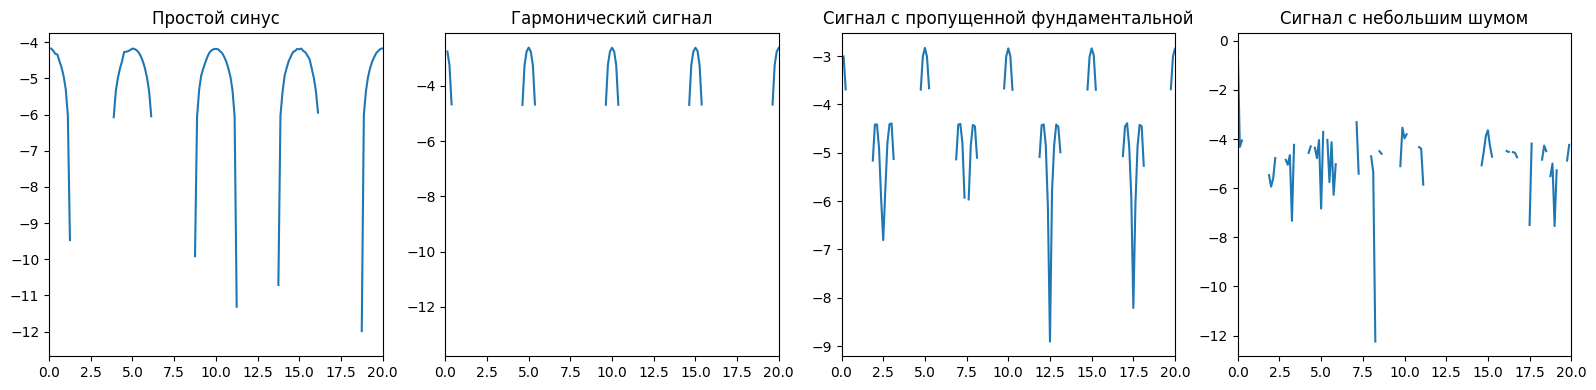

In [561]:
cepstrum_sine = compute_cepstrum(sine_wave)
quefrency = np.arange(len(cepstrum_sine)) / fs

cepstrum_harm = compute_cepstrum(harmonic_signal)
cepstrum_missing_f0 = compute_cepstrum(missing_f0)
cepstrum_noisy = compute_cepstrum(noisy_signal)

plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.plot(quefrency * 1000, np.log(cepstrum_sine))
plt.xlim(0, 20)
plt.title('Простой синус')

plt.subplot(1, 4, 2)
plt.plot(quefrency * 1000, np.log(cepstrum_harm))
plt.xlim(0, 20)
plt.title('Гармонический сигнал')

plt.subplot(1, 4, 3)
plt.plot(quefrency * 1000, np.log(cepstrum_missing_f0))
plt.xlim(0, 20)
plt.title('Сигнал с пропущенной фундаментальной')

plt.subplot(1, 4, 4)
plt.plot(quefrency * 1000, np.log(cepstrum_noisy))
plt.xlim(0, 20)
plt.title('Сигнал с небольшим шумом')

plt.tight_layout()
plt.show()

In [562]:
f0_est = estimate_by_cepstrum(sine_wave, fs, 50, 500)
f0_est

400.0

In [563]:
f0_est = estimate_by_cepstrum(harmonic_signal, fs, 50, 500)
f0_est

200.0

In [564]:
f0_est = estimate_by_cepstrum(missing_f0, fs, 50, 500)
f0_est

200.0

In [565]:
f0_est = estimate_by_cepstrum(noisy_signal, fs, 50, 500)
f0_est

140.35087719298244

Задание:
<br/> Кепстр: добиться того, чтобы для шумного сигнала кепстральный метод давал близкие к нужным значения 

Задание (*):
<br/> Гармоническое решето: попробовать преобразовать метод оценки кандидатов так, чтобы приоритет получали частоты, близкие к реальной f0